## Style-transfer Notebook:

This notebook implements style transfer by optimizing the input image to fit the styles of the output image.

### Disclaimer:
This notebook is based heavily on the style-transfer tutorial provided 
by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

I will be experimenting with different possibilites in this notebook <br />
### Major Differences/Change: <br />
1. Added visualization of convolutional layers to better understand extracted features (Done)
2. Modify to use Keras Pre-trained notebooks
3. Modify to use BFGS to optimize the image

In [1]:
# Loading the necessary libraries
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

import keras
# inception_resnet_v2 import InceptionResNetV2
from Utilities import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.3.0
2.0.9


In [3]:
## Loading a pre-trained Deep-Neural Network
import vgg16
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
model = vgg16.VGG16()

In [5]:
content_filename = 'images/buildings300.jpg'
content_image = load_image(content_filename, max_size=None)

In [6]:
session = tf.InteractiveSession(graph=model.graph)
feed_dict = model.create_feed_dict(image=content_image)
layers = model.get_layer_tensors([4])
print layers
# Calculate the output values of those layers when
# feeding the content-image to the model.
values = session.run(layers, feed_dict=feed_dict)
print values

[<tf.Tensor 'conv3_1/conv3_1:0' shape=(?, ?, ?, 256) dtype=float32>]
[array([[[[  1.32632359e+05,   0.00000000e+00,   2.74466075e+06, ...,
            1.15579641e+05,   8.54723594e+04,   1.73833078e+05],
         [  1.54653266e+05,   5.69749492e+04,   2.02821338e+06, ...,
            2.57277891e+05,   1.50330344e+05,   2.13524062e+05],
         [  1.26705586e+05,   9.95901953e+04,   1.84908762e+06, ...,
            2.38215750e+05,   1.21095461e+05,   1.37134047e+05],
         ..., 
         [  0.00000000e+00,   2.45659422e+05,   2.12087475e+06, ...,
            3.30952500e+05,   1.25636102e+05,   2.46480734e+05],
         [  0.00000000e+00,   8.22199453e+04,   2.44590850e+06, ...,
            2.26619828e+05,   1.08376969e+05,   2.41334438e+05],
         [  3.58367500e+04,   0.00000000e+00,   3.38378450e+06, ...,
            6.64151328e+04,   1.01604297e+05,   2.40363516e+05]],

        [[  3.71895938e+04,   2.62783281e+05,   1.86328912e+06, ...,
            0.00000000e+00,   1.10429000

In [7]:
ession = tf.InteractiveSession(graph=model.graph)
# Create a feed-dict with the content-image.
feed_dict = model.create_feed_dict(image=content_image)

# Get references to the tensors for the given layers.
layers = model.get_layer_tensors(layer_ids)

# Calculate the output values of those layers when
# feeding the content-image to the model.
values = session.run(layers, feed_dict=feed_dict)

# Set the model's graph as the default so we can add
# computational nodes to it. It is not always clear
# when this is necessary in TensorFlow, but if you
# want to re-use this code then it may be necessary.
with model.graph.as_default():
    # Initialize an empty list of loss-functions.
    layer_losses = []

    # For each layer and its corresponding values
    # for the content-image.
    for value, layer in zip(values, layers):
        # These are the values that are calculated
        # for this layer in the model when inputting
        # the content-image. Wrap it to ensure it
        # is a const - although this may be done
        # automatically by TensorFlow.
        value_const = tf.constant(value)

        # The loss-function for this layer is the
        # Mean Squared Error between the layer-values
        # when inputting the content- and mixed-images.
        # Note that the mixed-image is not calculated
        # yet, we are merely creating the operations
        # for calculating the MSE between those two.
        loss = mean_squared_error(layer, value_const)

        # Add the loss-function for this layer to the
        # list of loss-functions.
        layer_losses.append(loss)

    # The combined loss for all layers is just the average.
    # The loss-functions could be weighted differently for
    # each layer. You can try it and see what happens.
    total_loss = tf.reduce_mean(layer_losses)
        

<vgg16.VGG16 instance at 0x7ff4f4417f80>

In [5]:
def style_transfer(model, session, content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):

#     model = vgg16.VGG16()

#     # Create a TensorFlow-session.
#     session = tf.InteractiveSession(graph=model.graph)

#     # Print the names of the content-layers.
#     print("Content layers:")
#     print(model.get_layer_names(content_layer_ids))
#     print()

#     visualize_layers(session,model,content_image,content_layer_ids)
    
#     # Print the names of the style-layers.
#     print("Style layers:")
#     print(model.get_layer_names(style_layer_ids))
#     print()
    
#     visualize_layers(session,model,style_image,style_layer_ids)

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
#         print ". ", end=""

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Start of Example

In [7]:
style_filename = 'images/steampunk.jpg'
style_image = load_image(style_filename, max_size=None)

In [8]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

content_layer_ids = [4]

Content layers:
['conv3_1/conv3_1']
()
Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']
()


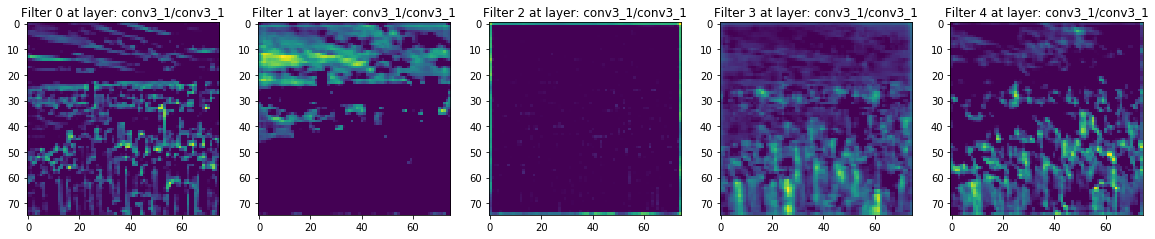

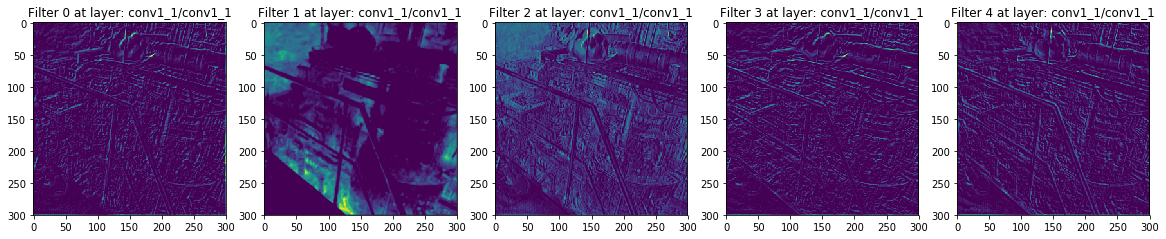

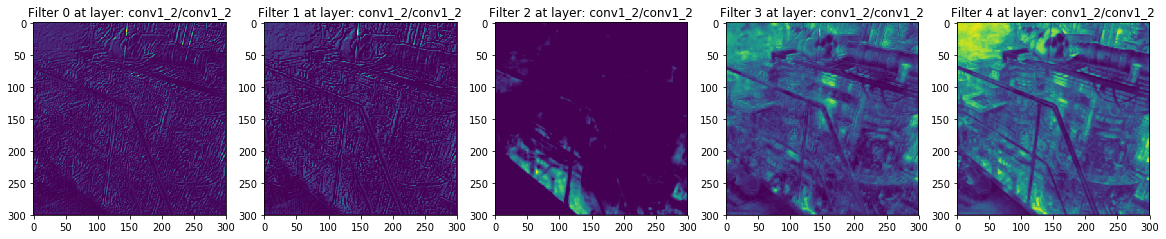

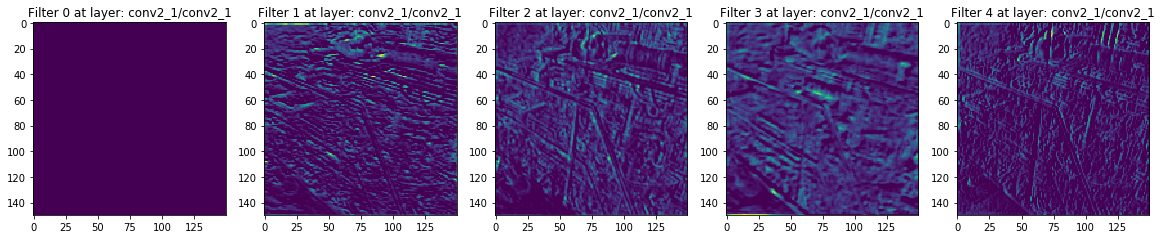

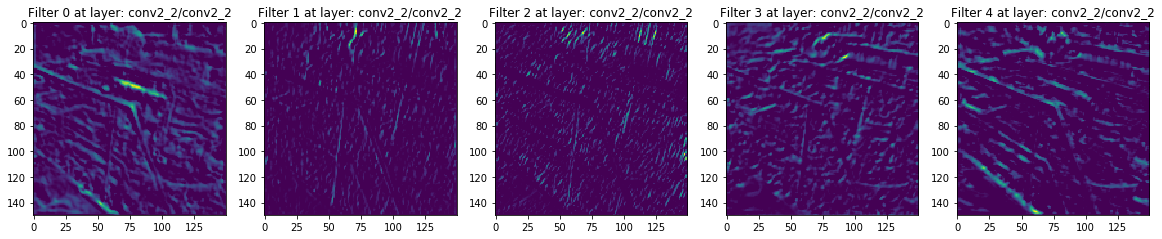

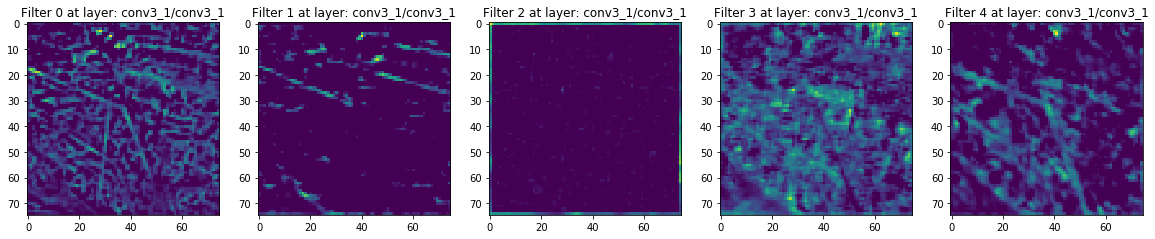

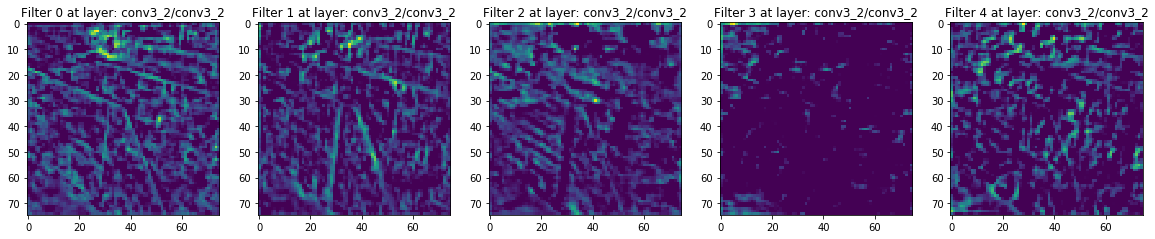

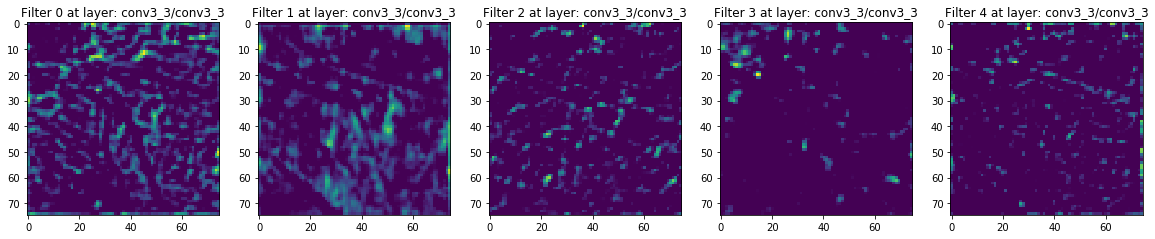

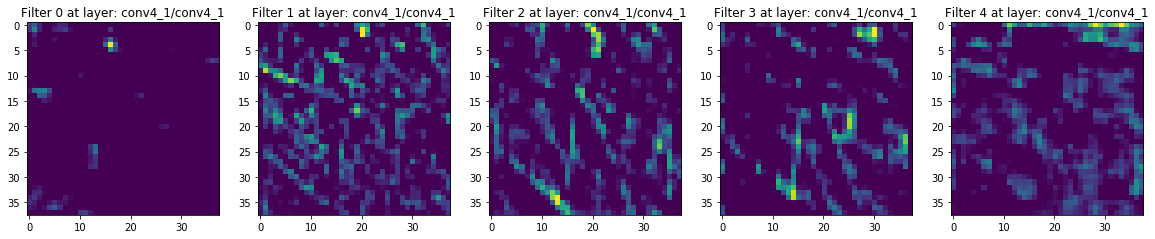

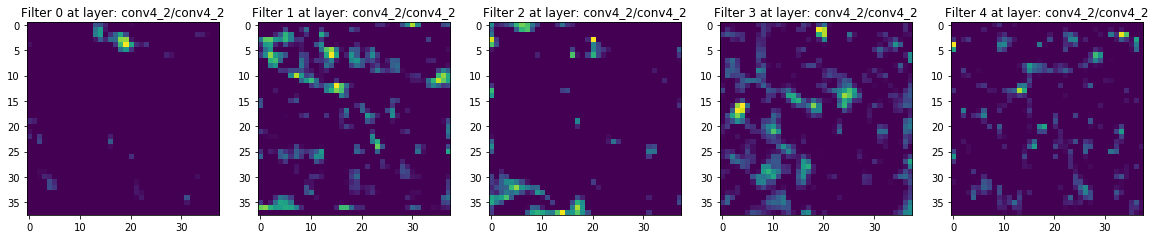

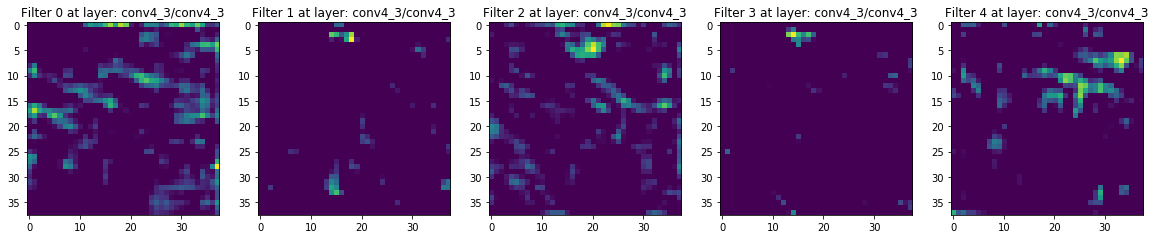

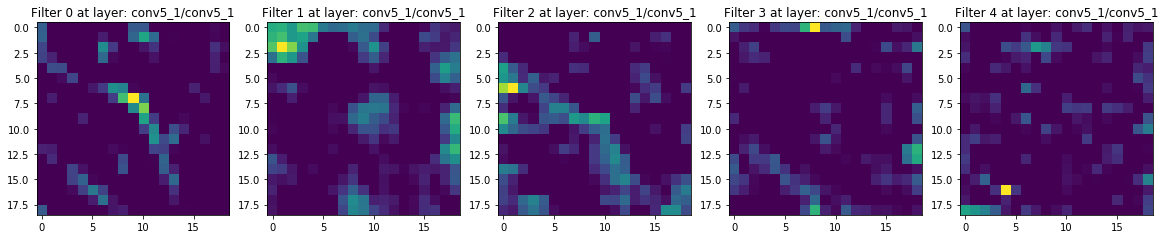

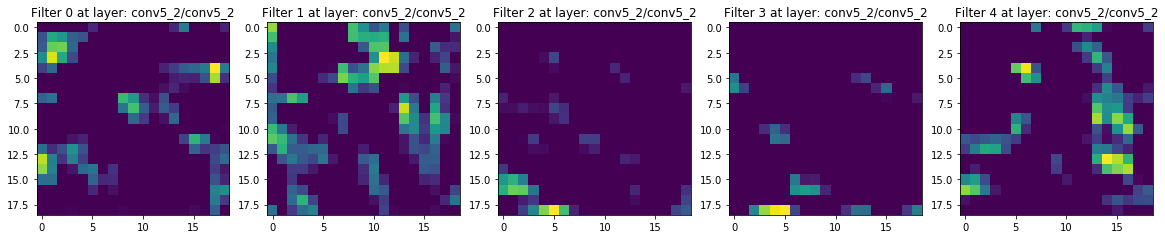

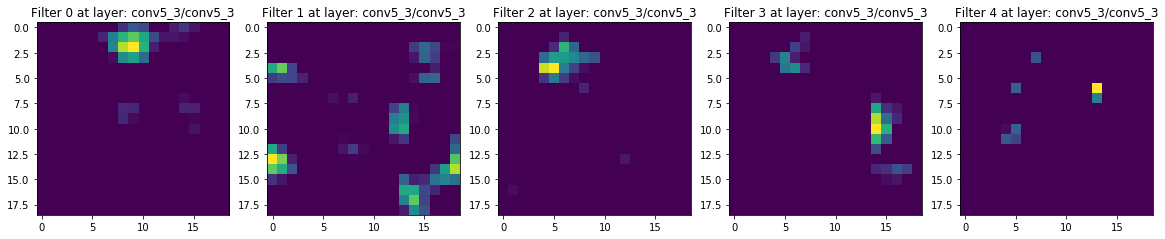

In [9]:
# Visualizing and controlling the layers used 

model = vgg16.VGG16()

# Create a TensorFlow-session.
session = tf.InteractiveSession(graph=model.graph)

# Print the names of the content-layers.
print("Content layers:")
print(model.get_layer_names(content_layer_ids))
print()

visualize_layers(session,model,content_image,content_layer_ids)

# Print the names of the style-layers.
print("Style layers:")
print(model.get_layer_names(style_layer_ids))
print()

visualize_layers(session,model,style_image,style_layer_ids)

()
('Iteration:', 0)
Weight Adj. for Content: 3.32e-11, Style: 2.33e-28, Denoise: 5.58e-06


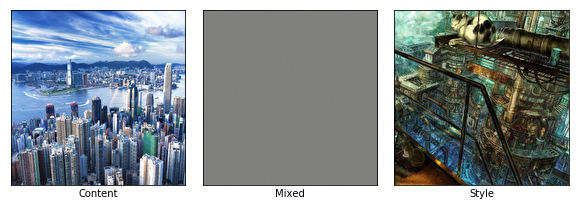

()
('Iteration:', 10)
Weight Adj. for Content: 4.53e-11, Style: 3.83e-28, Denoise: 4.66e-07


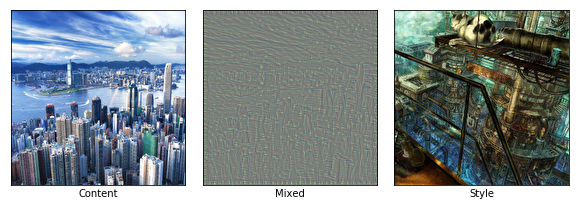

()
('Iteration:', 20)
Weight Adj. for Content: 5.29e-11, Style: 9.06e-28, Denoise: 2.04e-07


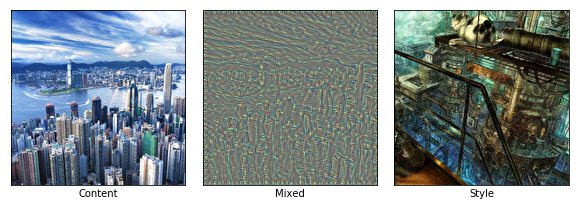

()
('Iteration:', 30)
Weight Adj. for Content: 5.77e-11, Style: 4.40e-27, Denoise: 1.69e-07


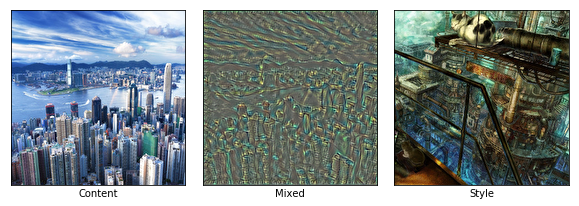

()
('Iteration:', 40)
Weight Adj. for Content: 5.79e-11, Style: 8.71e-27, Denoise: 1.62e-07


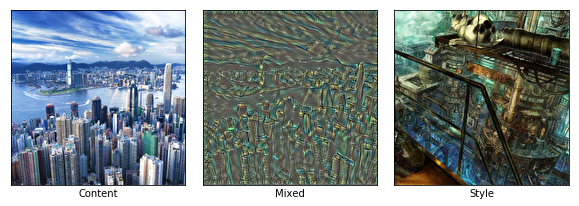

KeyboardInterrupt: 

In [10]:
# %%time
img = style_transfer(model, session, content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=200,
                     step_size=1.0)